# Aerosol size distribution observations

Here, I take aerosol size distribution data from 5 different observatories and process it to show annual trends in aerosol production and transport.

Import functions here.

In [1]:
from imports import (
        pd, np, xr, mpl, plt, sns, os,
        glob, datetime, sys, crt, LogNorm
    )

from functions import converttoN, average_aero_data # Function for working with this data format

#import matplotlib.dates as mdates
%matplotlib inline

base_dir = '/home/notebook/basics/saved_data/'

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Separate aero_dist files by observatory ##

Move to correct directory and list all files in it.

In [14]:
datadir = "/home/dda6cdc3-2d887a-2d48f7-2d917a-2d73b2d2822500/shared-ns1000k/inputs/Aerosol_sizedist_obs"
os.chdir(datadir)
aerofile = os.listdir()

Separate data file based on the observation location

In [15]:
sites = ['Zeppelin', 'ALERT', 'Barrow', 'Tiksi', 'Nord']
sitefiles = {}
for site in sites:
    temp_site_files = [x for x in aerofile if site in x]
    sitefiles[site] = temp_site_files

### For a single year's observation

I am using the average_aero_data function in functions.py to do this quickly

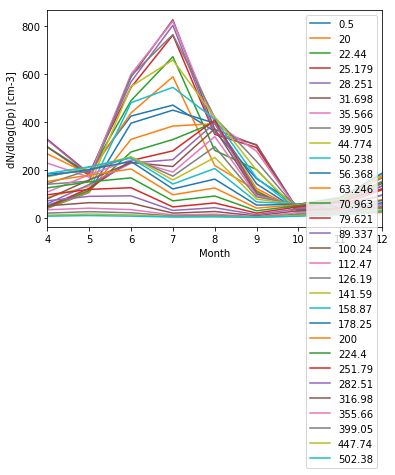

In [16]:
zepp = sitefiles[sites[0]]
file1 = zepp[0]
zepp1 = average_aero_data(file1)
monthlyavg = zepp1.groupby(zepp1.index.month).mean()
testplt1 = monthlyavg.plot()
testplt1.set_xlabel('Month'); testplt1.set_ylabel('dN/dlog(Dp) [cm-3]');

For a single observatory with different years, I just run the averaging function in a loop

This first example uses pandas more thoroughly and weights each observation equally in order to avoid months with few samples from contributing unequally.

In [17]:
observat = 'Zeppelin'
yeardata = pd.DataFrame()
for year in sitefiles[observat]:
    temp_dist = average_aero_data(year, monthavg = False)
#    pd.concat([yeardata, temp_dist])
    yeardata = yeardata.append(temp_dist)

Take a monthly average plot

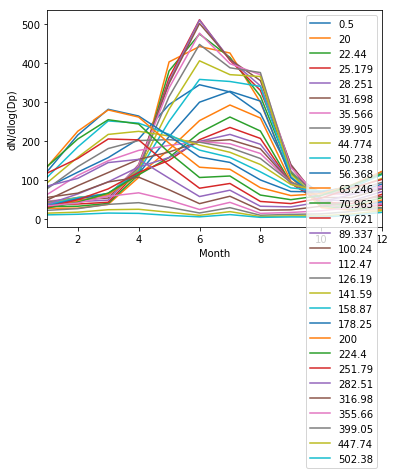

In [18]:
monthlyavg = yeardata.groupby(yeardata.index.month).mean()
zepp_all = monthlyavg.plot()
zepp_all.set_xlabel('Month'); zepp_all.set_ylabel('dN/dlog(Dp)');

Adjust to show how the size distribution evolves with the year

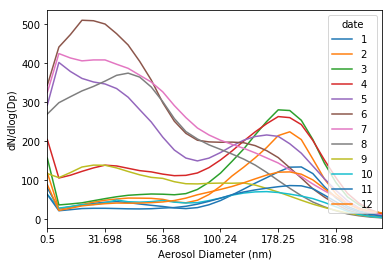

In [19]:
zepp_all_Dpx = monthlyavg.T.iloc[::1].dropna(axis=1)
zepp_all_plot = zepp_all_Dpx.plot()
zepp_all_plot.set_xlabel('Aerosol Diameter (nm)'); zepp_all_plot.set_ylabel('dN/dlog(Dp)');

## Convert units to Ni from dNi/dlog(Dp) 

Separate between Aitken,  Coarse, and Accumulation modes. Need to multiply out weighting by bin width first.
Aitkin 20 - 50 nm, Accumulation 50 - 100, Coarse > 100 um. 
Aerosol number concentration as dN/dLogDp [cm-3]

Here, I am using the converttoN function to get data with the accumulation modes calculated. The size buckets are hardcoded into the converttoN function.

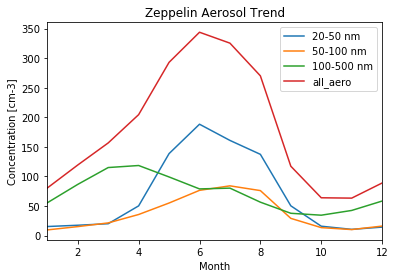

In [20]:
zeppelin_only = monthlyavg.copy()
obs_with_N = converttoN(zeppelin_only)
zepp_N = obs_with_N[['20-50 nm', '50-100 nm','100-500 nm', 'all_aero']].plot(title = (sites[0] + ' Aerosol Trend'), legend = True)
zepp_N.set(xlabel="Month", ylabel="Concentration [cm-3]");

Explanation of Zeppelin annual aerosol trend:
- The largest size distribution comes from transport from Southern latitudes when the Arctic dome expands in the winter. We would expect to see the large particles that contribute to Arctic haze follow this trend as well.
- The 20-50nm bin tracks secondary aerosols that form from phytoplankton emissions in the summer
- The 50-100nm bin includes Accumulation Mode particles that form from the coagulation of smaller particles.

## For all observatories

Combine datasets for different years and observatories

In [21]:
all_obs = {}
for obs in sites: # For each string describing an observation station
    temp_emp = []
    #print(obs)
    for year in sitefiles[obs]:  # For each year that obsevatory has data
#        print(year)
        temp_dist = average_aero_data(year) # Call an external function to return monthly distributions
        temp_emp.append(temp_dist)
    allyears = pd.concat(temp_emp)
    all_obs[obs] = allyears.groupby(allyears.index.month).mean() # Combine each year in a single pandas dataset and save in dict obj

Trying to do this more efficiently with pandas or xarray, but still using a dictionary :(

In [9]:
da = xr.Dataset()
all_obs = {}
for obs in sites: # For each string describing an observation station
    print(obs)
    _df = pd.DataFrame()
    for year in sitefiles[obs]:
        print(year)
        temp_dist = average_aero_data(year, monthavg = False)
        _df = _df.append(temp_dist)
    _loc_all = _df.groupby(_df.index.month).mean()
#        _xa = _loc_all.to_xarray()
    all_obs[obs] = _loc_all
    #da[obs] = _xa
    
#    break
#_xa#['0.5']

_fig = all_obs[obs].plot

Zeppelin
Zeppelin_2011_hourly.csv
Zeppelin_2015_hourly.csv
Zeppelin_2013_hourly.csv
Zeppelin_2012_hourly.csv
Zeppelin_2010_hourly.csv
ALERT
ALERT_2013_hourly.csv
ALERT_2012_hourly.csv
ALERT_2011_hourly.csv
Barrow
Barrow_2007_hourly.csv
Barrow_2008_hourly.csv
Barrow_2013_hourly.csv
Barrow_2009_hourly.csv
Barrow_2015_hourly.csv
Barrow_2014_hourly.csv
Tiksi
Tiksi_2013_hourly.csv
Tiksi_2014_hourly.csv
Tiksi_2015_hourly.csv
Nord
Station_Nord_2012_hourly.csv
Station_Nord_2013_hourly.csv
Station_Nord_2011_hourly.csv
Station_Nord_2010_hourly.csv


Ugly plot of the different bases (does not plot)

In [10]:
%%capture
# create subplots object of length len(sites)
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,15))
fig2, ax2 = plt.subplots(nrows=3, ncols=2, figsize=(10,15))
for i,obs in enumerate(sites):
    row = (i) // 2; col = (i) % 2;
    all_obs[obs].plot(ax = ax[row, col], title = obs, legend = False)
    temp_vs_size = all_obs[obs].T.iloc[::1]
    temp_vs_size.plot(ax = ax2[row, col], title = obs, legend = False)
    ax[row, col].set(xlabel="Month", ylabel="dN/dLogDp [cm-3]")
    ax2[row, col].set(xlabel="Diameter", ylabel="Concentration")

    #    all_obs[obs].plot(title= obs)
#fig.set_title('Size distr. vs time')
#fig.legend(); fig2.legend()
handles, labels = ax[0,0].get_legend_handles_labels()
handles2, labels2 = ax2[0,0].get_legend_handles_labels()

fig.legend(handles, labels, loc=[0.9, 0.4]); fig2.legend(handles2, labels2, loc=[0.9, 0.7]);

#fig

Here, I use the data divided between modes to convey the data more clearly.

Calculate and add the average over all observation centers

In [11]:
%%capture
fig3, ax3 = plt.subplots(nrows=2, ncols=3, figsize=(15,10));
all_obs_list = []
for i,obs in enumerate(sites):
    col = (i) // 2; row = (i) % 2;
    obs_with_N = converttoN(all_obs[obs])
    obs_with_N[['20-50 nm', '50-100 nm','100-500 nm', 'all_aero']].plot(ax = ax3[row, col], title = obs, legend = False);
#    ax3[row, col].set(xlabel="Month", ylabel="Concentration [cm-3]");
    ax3[row, col].set_ylabel('')
    ax3[row, col].set_xlabel('')
    all_obs_list.append(obs_with_N) # To average over all observatories
#fig3.legend(handles, labels, loc='upper left', title = 'Aerosol Modes')

all_place_obs = pd.concat(all_obs_list)

bigpanda = all_place_obs.groupby('date').mean() # Combine each year in a single pandas dataset
bigpanda[['20-50 nm', '50-100 nm','100-500 nm', 'all_aero']].plot(ax = ax3[1, 2], title = 'Average', legend = False)
handles, labels = ax3[0,0].get_legend_handles_labels()
fig3.legend(handles, labels, loc='upper left', title = 'Aerosol Modes');
#ax3[1, 2].set(xlabel="Month", ylabel="Concentration [cm-3]");
fig3.suptitle('Annual Aerosol Trends by Observatory', fontsize=24);
fig3.text(0.5, 0.06, 'Month', ha='center', fontsize=20)
fig3.text(0.07, 0.5, 'Secondary Organic Aerosol MMR (kg/kg)', va='center', rotation='vertical', fontsize=20)

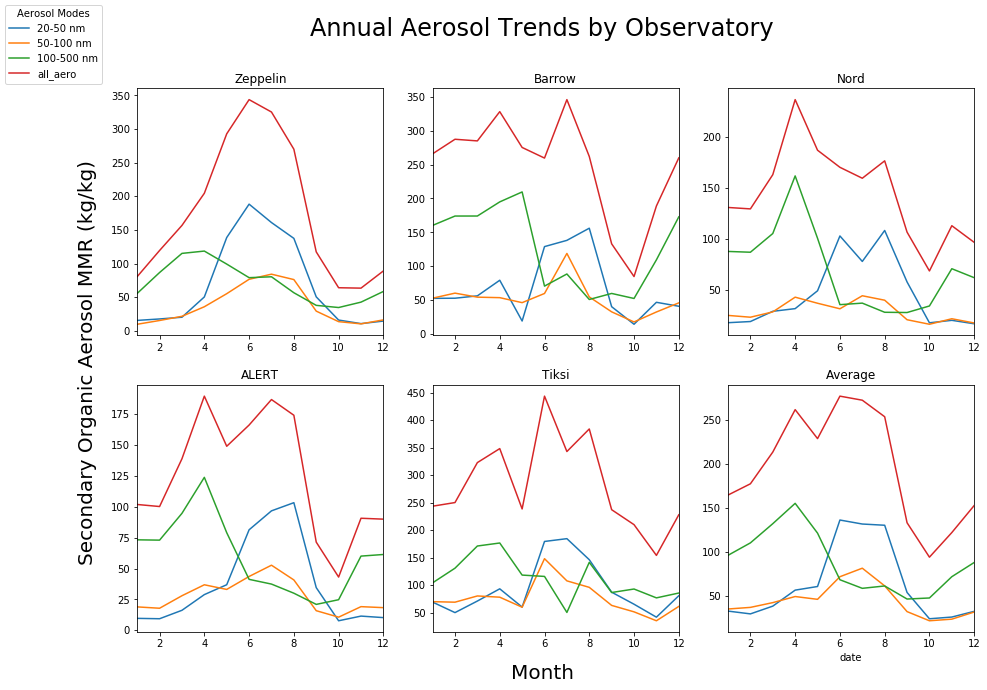

In [12]:
fig3

In [27]:
filename = "obs_size_dist.png"
plt.savefig(base_dir + filename,format = 'png', dpi = 400)
plt.clf()

Attempt to save figure

In [13]:
filename = "obs_aero_trends"
fig3.savefig(base_dir + filename  + '.pdf')
fig3.clf()

## The takeaway

    -general aerosol trends at Arctic stations
    -variations between stations
    -relatively few measurements (2-6 years at each observatory)
    -Cannot identify marine aerosols from this kind of measurement